In [1]:
data_dir = "SagSolDataset"

In [2]:
import os
os.listdir(data_dir)

['Sol', 'Sagadonulmez', 'Sag', 'Soladonulmez']

In [3]:
for cls in os.listdir(data_dir):
  print(cls, ":", len(os.listdir(data_dir + "/" + cls)))

Sol : 371
Sagadonulmez : 371
Sag : 371
Soladonulmez : 371


In [4]:
from torchvision.datasets import ImageFolder
dataset = ImageFolder(data_dir)
len(dataset)

1484

In [5]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=95x89 at 0x7FDC34422070>, 0)

In [6]:
dataset.classes

['Sag', 'Sagadonulmez', 'Sol', 'Soladonulmez']

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

2


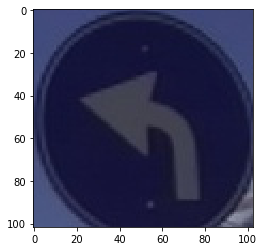

In [8]:
img, label = dataset[755]
plt.imshow(img)
print(label)

In [9]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ColorJitter(brightness=0.5),
    tt.ToTensor()
]))

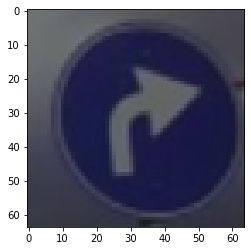

In [10]:
img, label = dataset[0]
plt.imshow(img.permute((1, 2, 0)))

In [11]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [12]:
val_pct = 0.1
val_size = int(val_pct * len(dataset))
train_size = len(dataset) - val_size

train_size, val_size

(1336, 148)

In [13]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(1336, 148)

In [14]:
from torch.utils.data import DataLoader

batch_size = 32

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=3,
                      pin_memory=True)

valid_dl = DataLoader(valid_ds,
                      batch_size,
                      num_workers=3,
                      pin_memory=True)

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(18,18))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

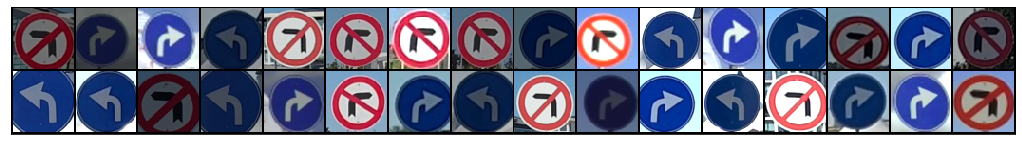

In [16]:
show_batch(train_dl)

In [17]:
import torch 

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
torch.cuda.is_available()

False

In [19]:
device = get_default_device()
device

device(type='cpu')

In [20]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [21]:
dataset[0][0].shape

torch.Size([3, 64, 64])

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    """Calculate loss for a batch of traning data"""
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    """Calculate loss & accuracy for a batch of validation data"""
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss":loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [23]:
"Evaluates the model's performance on the validation set"
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [24]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class LittleModel(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 64, pool=True) # 1  
        self.conv3 = conv_block(64, 32, pool=True) # 1  
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                        nn.Flatten(), # 128 x 512
                                        nn.Linear(32, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.classifier(out)
        return out

In [25]:
model = to_device(LittleModel(3, len(dataset.classes)), device)
model

LittleModel(
  (conv1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveMaxPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=32, out_features=4, 

In [26]:
for batch in train_dl:
  images, labels = batch
  print("images.shape", images.shape)
  print("images.device", images.device)
  preds = model(images)
  print("preds.shape", preds.shape)
  break

images.shape torch.Size([32, 3, 64, 64])
images.device cpu
preds.shape torch.Size([32, 4])


/home/ubuntu/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [27]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 1.380312204360962, 'val_acc': 0.26624998450279236}]

In [28]:
history += fit(4, 0.01, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.8827, val_loss: 0.5209, val_acc: 0.8300
Epoch [1], train_loss: 0.4310, val_loss: 0.2732, val_acc: 0.8800
Epoch [2], train_loss: 0.1777, val_loss: 0.1359, val_acc: 0.9300
Epoch [3], train_loss: 0.1270, val_loss: 0.0605, val_acc: 0.9900


In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

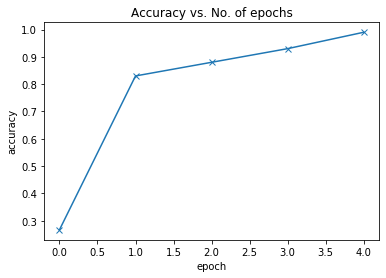

In [30]:
plot_accuracies(history)

In [31]:
torch.save(model,'sagsolpytorch.h5')

In [32]:
loaded_model = torch.load('sagsolpytorch.h5')

'Soladonulmez'

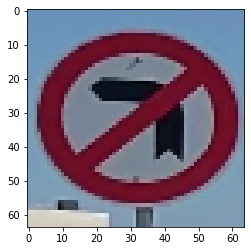

In [48]:
import cv2
img = cv2.imread("407.jpg")
img = cv2.resize(img, (64, 64))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = img / 255.0
plt.imshow(img)
img = torch.from_numpy(img).permute(2, 0, 1)
img = img.unsqueeze(0)
img = img.float()
pred = loaded_model(img.to(device))
pred = dataset.classes[int(torch.argmax(pred))]
pred

In [37]:
import numpy as np
pred = torch.max(pred)

In [38]:
int(pred.indices[0])

2